# CMEPDA Project: Convolutional Neural Networks for the classification of Microcalcification in Digital Mammography

- **STEP 1**: Import data set, visualize random images, and make some data exploration;
- **STEP 2**: Build, train and evaluate the CNN;
- **STEP 3**: Data aumentation procedure;
- **STEP 4**: Compare the performances of the two models evaluating:
  - the area under the receiver-operating characteristic curve (AUC)
  - specificity
  - sensitivity
  - F1-score
  - accuracy
- **STEP 5**: Cross validation procedure.


In [69]:
import os
import random
import glob
import logging
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage
from skimage.io import imread
import numpy as np
import pandas as pd
import PIL
# Layers needed in a CNN
from keras.layers import Input, Conv2D, MaxPooling2D, MaxPooling3D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import numpy as np
from math import *
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# Load model
from keras.models import load_model
# Cross validation
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from numpy import interp
from sklearn.model_selection import KFold

# STEP 1: Import data set, visualize random images, and make some data exploration

In [70]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Reading the images


In [72]:
def read_imgs(dataset_path, classes):
    """Function reading all the images in a given folder which already contains
    two subfolder.

    Parameters
    ----------
        dataset_path : str
            Path to the image folder.
        classes : list
            0 and 1 mean normal tissue and microcalcification clusters, respectively.

    Returns
    -------
        array: numpy_array
            Array containing the value of image/label.

    """
    tmp = []
    labels = []
    for cls in classes:
        try:
            fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
            logging.info(f'Read images from class {cls}')
            tmp += [imread(fname) for fname in fnames]
            labels += len(fnames)*[cls]
        except Exception as e_error:
            raise Exception('Image or path not found') from e_error

    return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)


Load the train and test sets

In [73]:
train_dataset_path = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train'
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Test'
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

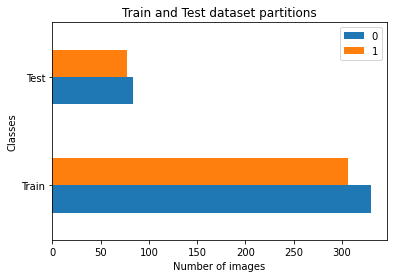

In [74]:
def bar_plot(y_train, y_test):
    """Plot an horizontal bar graph
    showing the relative partition of the two given dataset.

    Parameters
    ----------
    y_train : numpy_array
        Labels for the train data set.
    y_test : numpy_array 
        Labels for the train data set.

    Returns
    -------
    None

    """

    data = {'0': [sum(map(lambda x : x == 0, y_train)), sum(map(lambda x : x == 0, y_test))],
            '1': [sum(map(lambda x : x == 1, y_train)), sum(map(lambda x : x == 1, y_test))]
           }
    df = pd.DataFrame(data,columns=['0','1'], index = ['Train','Test'])
    df.plot.barh()
    plt.title('Train and Test dataset partitions')
    plt.ylabel('Classes')
    plt.xlabel('Number of images')
    plt.show()

bar_plot(y_train, y_test)

In [75]:
def count_labels(y_train, y_test, verbose=True):
    """Count the number of items in the set.

    Parameters
    ----------
    y_train : numpy_array
        Labels for the train data set.
    y_test : numpy_array 
        Labels for the test data set.
    verbose : bool, optional
        Print the number of items in the set. Defaults to True.

    Returns
    -------
    data : pandas dataframe.
        Dataframe containing the total number of items for a specific label and set.

    """
    count_0_train = sum(map(lambda label : label == 0, y_train))
    count_1_train = sum(map(lambda label : label == 1, y_train))
    count_0_test = sum(map(lambda label : label == 0, y_test))
    count_1_test = sum(map(lambda label : label == 1, y_test))

    dict = {'Label': ['0', '1'],
        'Train': [count_0_train, count_1_train],
        'Test': [count_0_test, count_1_test]}

    data = pd.DataFrame(dict)

    if verbose:
        print(data.to_string(index=False))

    return data

data = count_labels(y_train, y_test, verbose=True)

Label  Train  Test
    0    330    84
    1    306    77


## Image visualization

We can visualize a single image

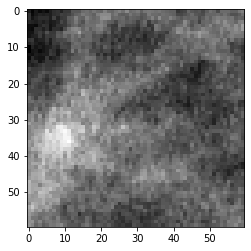

In [76]:
plt.imshow(np.squeeze(x_train[291]), cmap='gray')

and also random multiple images

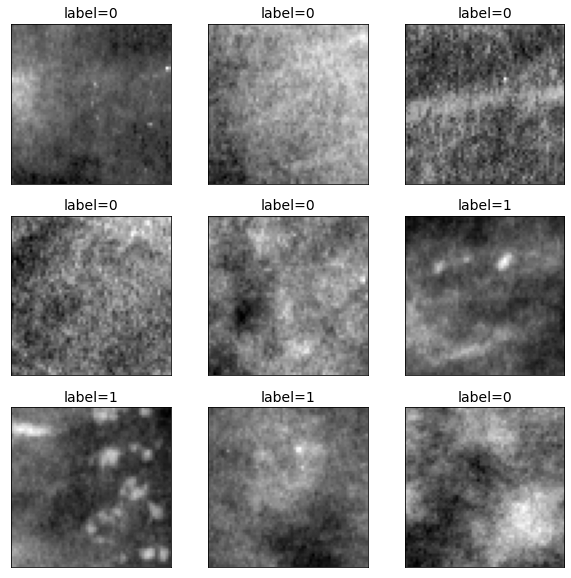

In [77]:
def plot_random_images(X, y, n_x=3, n_y=3):
    """Plot an image with given label randomly selected from a given dataset.

    Parameters
    ----------
    X : numpy_array
        Image pixel intensity values.
    y : numpy_array
        Labels for the train data set.
    n_x : int
        Number of images in the rows.
    n_y : int
        Number of images in the columns.

    Returns
    -------
    None

    """

    plt.figure(figsize=(10,10))

    for i in range(n_x * n_y):
        plt.subplot(n_x, n_y, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        random_index = np.random.randint(len(y))
        plt.imshow(np.squeeze(X[random_index]), cmap='gray')
        plt.title(f"label={y[random_index]}", fontsize=14)

    plt.show()

plot_random_images(X=x_train, y=y_train, n_x=3, n_y=3)

## Train and Evalutation split

To define the train and validation set we can use the function **train_test_split**, which split array y_train labels into random train and test subsets by proportions.

In this case, the first train data set contains 75% of the total number of 396 images, randomly selected within the sample.



Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [78]:
def split_dataset(X_train, y_train, X_test, y_test, perc=0.2, verbose=True):
    """Split the train dataset for train and validation set.

    Parameters
    ----------
        X_train : numpy_array
            Images of train set.
        y_train : numpy_array
            Labels of train set.
        X_test : numpy_array
            Images of test set.
        y_test : numpy_array
            Labels of test set.
        perc : float
            Percentual of items for the validation set.

    Returns
    -------
        X_train_split : numpy_array
            Split images data set for training.
        X_val : numpy_array
            Image data set for validation.
        y_train_split : numpy_array
            Split label data set for training.
        y_val : numpy_array
            Label data set for validation.

    """

    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train,
        test_size=perc,
        random_state=11
        )

    count_0_train = sum(map(lambda label : label == 0, y_train))
    count_1_train = sum(map(lambda label : label == 1, y_train))
    count_0_val = sum(map(lambda label : label == 0, y_val))
    count_1_val = sum(map(lambda label : label == 1, y_val))
    count_0_test = sum(map(lambda label : label == 0, y_test))
    count_1_test = sum(map(lambda label : label == 1, y_test))

    dict = {'Label': ['0', '1'],
        'Train': [count_0_train, count_1_train],
        'Validation': [count_0_val, count_1_val],
        'Test': [count_0_test, count_1_test]}

    data = pd.DataFrame(dict)

    if verbose:
        print(data.to_string(index=False))

    return X_train_split, X_val, y_train_split, y_val

x_train_split, x_val, y_train_split, y_val = split_dataset(x_train, y_train, x_test, y_test, perc=0.25, verbose=True)

Label  Train  Validation  Test
    0    330          79    84
    1    306          80    77


#  **STEP 2**: Build, train and evaluate the CNN

## Define Network Architecture

In [79]:
def cnn_model(shape=(60, 60, 1), verbose=False):
    """
    CNN for microcalcification clusters classification.

    Parameters
    ----------
    shape : tuple, optional
        The first parameter.
    verbose : bool, optional
        Enables the printing of the summary. Defaults to False.

    Returns
    -------
    model
        Return the convolutional neural network.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=shape))
    model.add(MaxPooling2D((2, 2), name='maxpool_1'))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(MaxPooling2D((2, 2), name='maxpool_2'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(MaxPooling2D((2, 2), name='maxpool_3'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
    model.add(MaxPooling2D((2, 2), name='maxpool_4'))

    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu', name='dense_2'))
    model.add(Dense(128, activation='relu', name='dense_3'))
    model.add(Dense(1, activation='sigmoid', name='output'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    if verbose:
      model.summary()
  
    return model

In [80]:
INPUT_SHAPE = (60, 60, 1)
model = cnn_model(shape=INPUT_SHAPE,  verbose=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 60, 60, 32)        320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 30, 30, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 30, 30, 64)        18496     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 15, 15, 64)        0         
                                                                 
 dropout_30 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 15, 15, 128)       73856     
                                                                 
 maxpool_3 (MaxPooling2D)    (None, 7, 7, 128)       

## Sketch of network's architecture

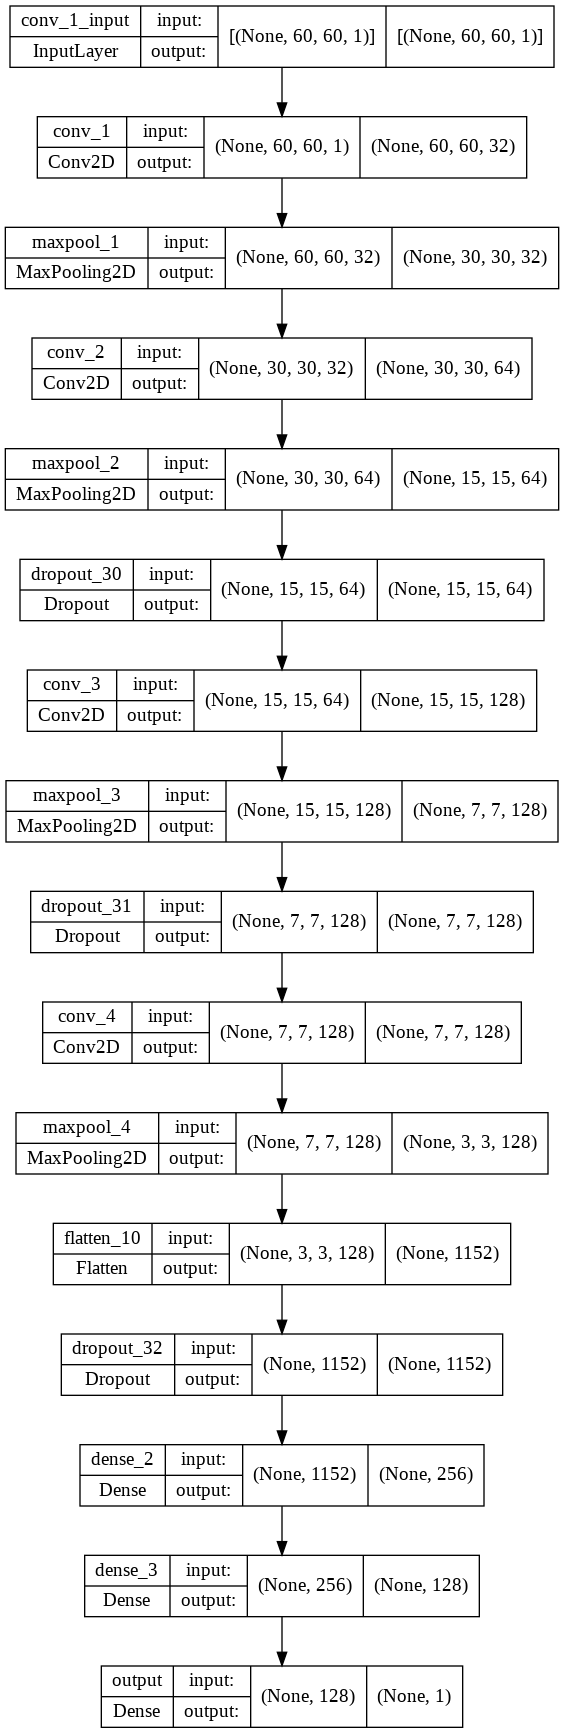

In [81]:
plot_model(model, to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True
)

Image(retina=True, filename='model_plot.png')

## Training

In [82]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath="/content/tmp/checkpoint",
    monitor='val_accuracy', 
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=1
    )

history = model.fit(x_train, 
                    y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=25,
                    shuffle=True,
                    validation_freq=1,
                    #callbacks=[checkpoint]
                    )

Epoch 1/25
20/20 [==============================] - 7s 316ms/step - loss: 0.6722 - accuracy: 0.5597 - val_loss: 0.6385 - val_accuracy: 0.7484
Epoch 2/25
20/20 [==============================] - 6s 302ms/step - loss: 0.6334 - accuracy: 0.6950 - val_loss: 0.5516 - val_accuracy: 0.7610
Epoch 3/25
20/20 [==============================] - 6s 303ms/step - loss: 0.5863 - accuracy: 0.6981 - val_loss: 0.5744 - val_accuracy: 0.6792
Epoch 4/25
20/20 [==============================] - 6s 301ms/step - loss: 0.5460 - accuracy: 0.7075 - val_loss: 0.5029 - val_accuracy: 0.7610
Epoch 5/25
20/20 [==============================] - 6s 306ms/step - loss: 0.5289 - accuracy: 0.7075 - val_loss: 0.4979 - val_accuracy: 0.7610
Epoch 6/25
20/20 [==============================] - 6s 302ms/step - loss: 0.5334 - accuracy: 0.7170 - val_loss: 0.5310 - val_accuracy: 0.7673
Epoch 7/25
20/20 [==============================] - 6s 299ms/step - loss: 0.5294 - accuracy: 0.7233 - val_loss: 0.5026 - val_accuracy: 0.7736
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


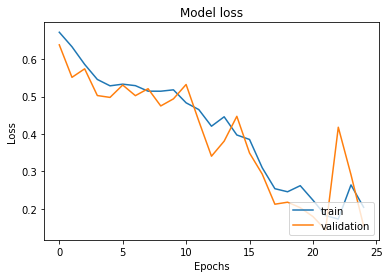

In [83]:
# Training history
print(history.history.keys())
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.yscale('log')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

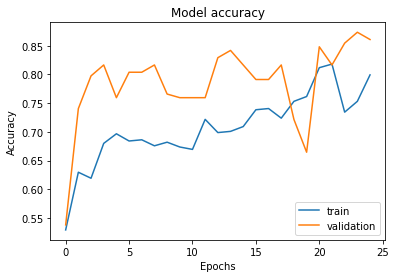

In [121]:
# Accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

## Prediction and performace on validation data

Evaluate network performace on validation data

In [85]:
y_val_pred = model.predict(x_val)

val_accuracy_score = accuracy_score(y_val, y_val_pred.round())
print(f'\nValidation accuracy score: {val_accuracy_score:.2f}')


Validation accuracy score: 0.95


## Correct/Incorrect classification samples

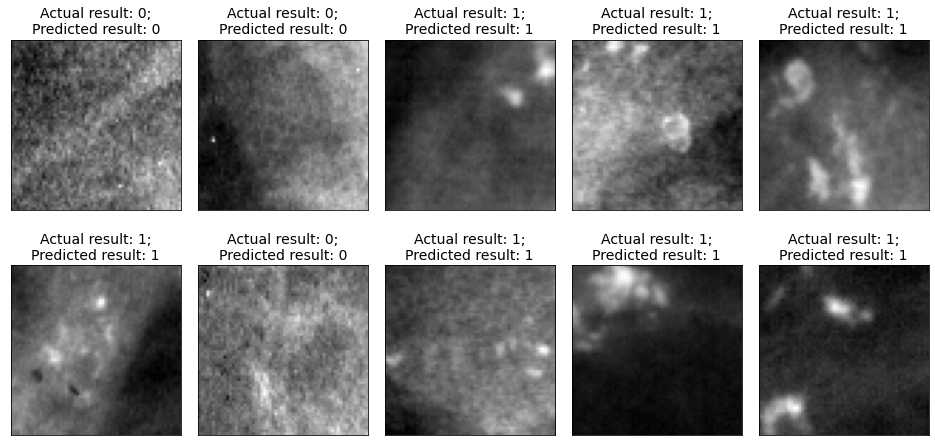

In [86]:
def plot_correct_pred(y, y_pred, x):
    """
    Plot several images correctly classified.

    Parameters
    ----------
    y : numpy array
        Original labels.
    y_pred : numpy array
        Predicted labels.
    x : numpy array
        Original images.

    Returns
    -------
    None
    """
    prop_class=[]

    for i in range(len(y)):
        if(y[i]==y_pred.round()[i]):
            prop_class.append(i)

    random_idx_list = np.random.permutation(prop_class)
  
    plt.figure(figsize=(15,15))

    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(x[random_idx_list[i]]), cmap='gray')
        plt.title(f"Actual result: {y[random_idx_list[i]]};\nPredicted result: {int(y_pred.round()[random_idx_list[i]])}", fontsize=14, color='black')
        plt.subplots_adjust(left=0.05,
                            bottom=0.001, 
                            right=0.9, 
                            top=0.4, 
                            wspace=0.1, 
                            hspace=0.1
                            )
    plt.show()

plot_correct_pred(y_val, y_val_pred, x_val)

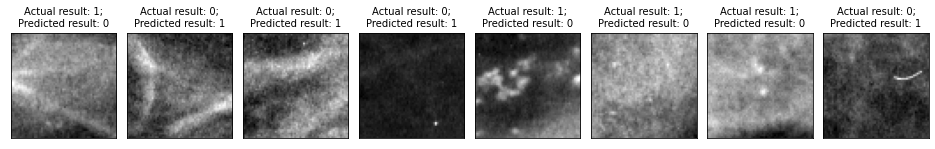

In [87]:
def plot_mis_pred(y, y_pred, x):
    """
    Plot several images uncorrectly classified.

    Parameters
    ----------
    y : numpy array
        Original labels.
    y_pred : numpy array
        Predicted labels.
    x : numpy array
        Original images.

    Returns
    -------
    None
    """

    mis_class=[]

    for i in range(len(y)):
        if(y[i]!=y_pred.round()[i]):
            mis_class.append(i)

    random_idx_list = np.random.permutation(mis_class)
  
    plt.figure(figsize=(15,15))

    if (len(mis_class) >= 10):
      for i in range(10):
          plt.subplot(2,5,i+1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(np.squeeze(x[random_idx_list[i]]), cmap='gray')
          plt.title(f"Actual result: {y[random_idx_list[i]]};\nPredicted result: {int(y_pred.round()[random_idx_list[i]])}", fontsize=14, color='black')
    else:
      for i in range(len(mis_class)):
          plt.subplot(1, len(mis_class), i+1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(np.squeeze(x[random_idx_list[i]]), cmap='gray')
          plt.title(f"Actual result: {y[random_idx_list[i]]};\nPredicted result: {int(y_pred.round()[random_idx_list[i]])}", fontsize=10, color='black')
  
    plt.subplots_adjust(left=0.05,
                        bottom=0.001, 
                        right=0.9, 
                        top=0.4, 
                        wspace=0.1, 
                        hspace=0.1)
    plt.show()

plot_mis_pred(y_val, y_val_pred, x_val)

### Save the trained network
We can save the network to use.

https://www.tensorflow.org/guide/keras/save_and_serialize#:~:text=There%20are%20two%20formats%20you,you%20use%20model.save()%20

In [91]:
model.save('/content/gdrive/MyDrive/cnn_model/model.h5')

## Prediction and performace on test data

Evaluate network performace on test data

In [92]:
from tensorflow import keras
model_to_test = keras.models.load_model('/content/gdrive/MyDrive/cnn_model/model.h5')


y_test_pred = model_to_test.predict(x_test)

test_accuracy_score = accuracy_score(y_test, y_test_pred.round())
print(f'\nTest accuracy score: {test_accuracy_score:.2f}')


Test accuracy score: 0.94


## Correct/Incorrect classification samples

We can visualize some correctly classified images:

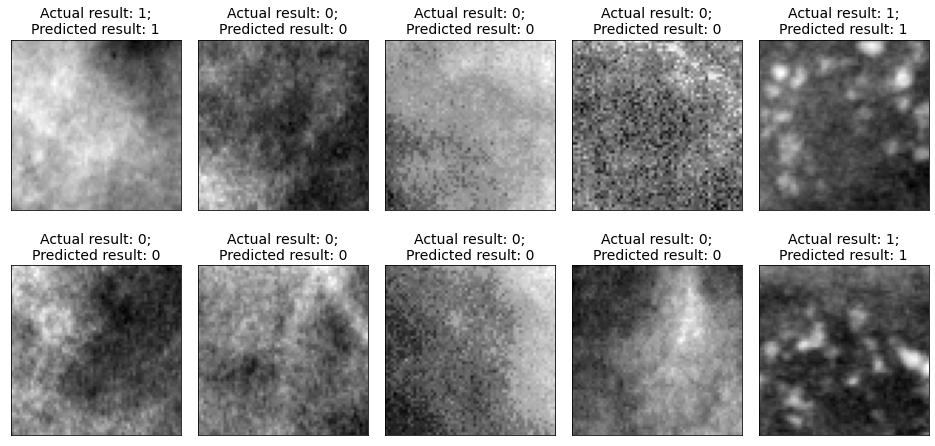

In [93]:
plot_correct_pred(y_test, y_test_pred, x_test)

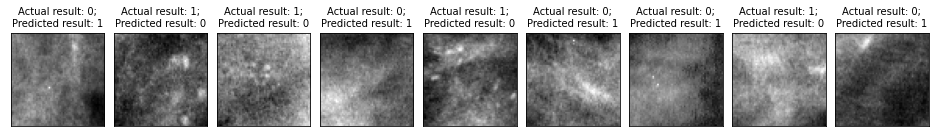

In [94]:
plot_mis_pred(y_test, y_test_pred, x_test)

## Confusion matrix

Confusion matrix, without normalization
[[79  5]
 [ 4 73]]


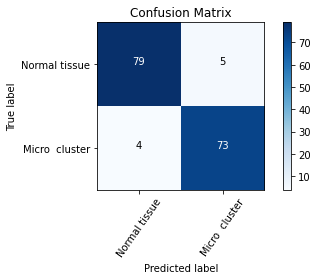

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.

    Parameters
    ----------
    cm : sklearn object
        Confusion matrix metrics computed with sklearn
    classes : str
        Binary classification labels.
    title : str
        Title of plot.
    cmap : matplotlib object
        Colors of the matrix.

    Returns
    -------
    Fig
        Show the confusion matrix plot.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(y_test, y_test_pred.round())
cm_plot_label =['Normal tissue', 'Micro  cluster']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix')

## ROC curve

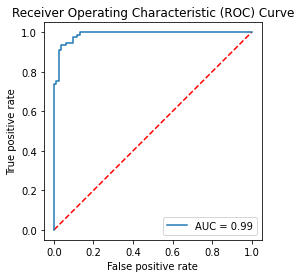

In [96]:
def plot_roc_curve(y_test, y_test_pred):
    """
    Plot the Receiver Operating Characteristic (ROC) curve.

    Parameters
    ----------
    y_test : numpy array
        Original labels of test set.
    y_test_pred : numpy array
        Predicted labels of test set.

    Returns
    -------
    Fig
        Show the roc curve plot.
    """

    roc_log = roc_auc_score(y_test, y_test_pred)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_test_pred) 
    area_under_curve = auc(false_positive_rate, true_positive_rate)

    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(false_positive_rate, true_positive_rate, label=f'AUC = {area_under_curve:.2f}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

plot_roc_curve(y_test, y_test_pred)

### Classification report

In [98]:
print(classification_report(y_test, y_test_pred.round()))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        84
           1       0.94      0.95      0.94        77

    accuracy                           0.94       161
   macro avg       0.94      0.94      0.94       161
weighted avg       0.94      0.94      0.94       161



# **STEP 3**: Data aumentation procedure
Convert to PNG
(needed to run ImageDataGenerator)

**NOTE**:

the number of samples does not increase. What happens is that the augmentations are applied every time a sample is loaded.
This means that the model doesn’t see the exact same image each epoch which improves generalization and prevents overfitting.
So the model just see the different versions of the image for each epoch and the number of samples remains the same.

In [101]:
def convert_to_png(fname, dest_folder):
    """
    Convert the extension of the given image from .pgm to .png.
    The new image is converted in gray scale and saved in the dest_folder.

    Parameters
    ----------
    fname : str
        Path to the input image with extension .pgm.
    dest_folder : str
        Destination folder in which save the new images with png extension.

    Returns
    -------
    None

    """
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    dest_fname = os.path.basename(fname).replace('.pgm', '.png')
    dest_fname = os.path.join(dest_folder, dest_fname)
    PIL.Image.open(fname).convert('L').save(dest_fname) # L (8-bit pixels, black and white)
    

In [103]:
TRAIN_PATH = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train'
TEST_PATH = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Test'

for data_path in [TRAIN_PATH, TEST_PATH]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)

## Perform  data augmentation 

In [106]:
def data_aug(train_dataset_path, img_width=60, img_height=60, batch_size=32):
    """
    Data augmentation procedure.

    Parameters
    ----------
    train_dataset_path : str
        Path to the input train data set.
    img_width : int
        X-dimension of the image
    img_height : int
        Y-dimension of the image
    batch_size : int
        Batch size

    Returns
    -------
    train_gen : ImageDataGenerator object
        Generated train data set.
    val_gen : ImageDataGenerator object
        Generated validation set.

    """

    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.25
        )
        
    train_gen = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(img_width, img_height),
        color_mode='grayscale', 
        class_mode='binary',
        subset='training'
        )

    val_gen = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='binary',
        subset='validation'
        )
    return train_gen, val_gen


TRAIN_PATH = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train_png'
BATCH_SIZE = 32
IMG_WITDH, IMG_HEIGHT = (60, 60)

train_gen, val_gen = data_aug(train_dataset_path=TRAIN_PATH,
                              img_width=IMG_WITDH,
                              img_height=IMG_HEIGHT,
                              batch_size=BATCH_SIZE
                              )

Found 478 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


## Effect of the data augmentation on a single image

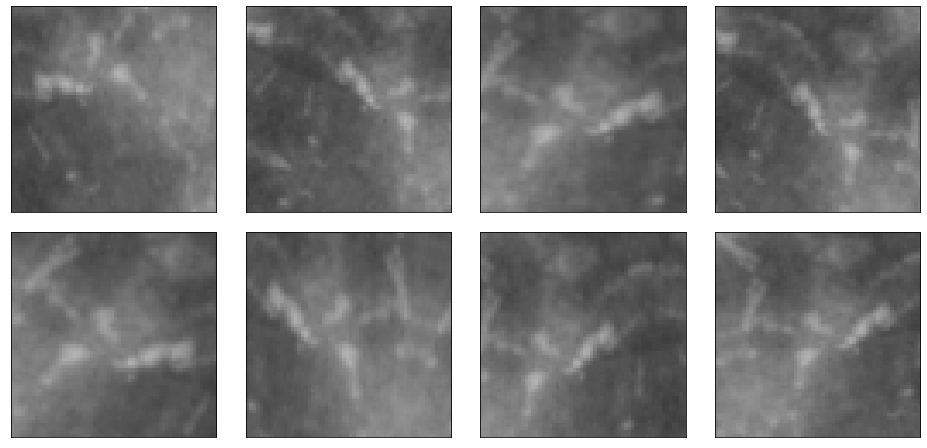

In [107]:
def single_image_aug(image_path, show=True):
    """
    Show the effect of the data aumentation procedure --based on ImageDataGenerator-- 
    showing a given single image.

    Parameters
    ----------
    image_path : str
        Path to the input train data set.
    show : bool
        If True, shows the tranformed image.

    Returns
    -------
    Fig
    
    """

    img = keras.preprocessing.image.load_img(image_path, target_size=(60, 60, 1))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #rescale=1./255,  # è già scalato tra 0 e 1. Se lo metto, vedo tutto nero.
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.3)

    pic = datagen.flow(img, batch_size=1)

    if show:
        plt.figure(figsize=(15,15))
        for i in range(1,9):
            plt.subplot(2, 4, i)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_, cmap='gray')
            plt.subplots_adjust(left=0.05,
            bottom=0.001, 
            right=0.9, 
            top=0.4, 
            wspace=0.1, 
            hspace=0.1)

        plt.show()

IMG_PATH = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train_png/1/0042t1_1_1_1.png_2.png'
single_image_aug(image_path=IMG_PATH, show=True)

In [108]:
train_gen.next()[0].shape

(32, 60, 60, 1)

## Fit model on augmented dataset

In [109]:
checkpoint = ModelCheckpoint(
    filepath="content/gdrive/MyDrive/cnn_model/augmented.h5", 
    monitor='val_accuracy', 
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=1
    )

aug_model = cnn_model()
aug_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = aug_model.fit(train_gen,
                    batch_size=32,
                    validation_data=val_gen,
                    epochs=25,
                    shuffle=True,
                    validation_freq=1,
                    callbacks=[checkpoint]
                    )

Epoch 1/25


 1/15 [=>............................] - ETA: 18s - loss: 0.6930 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.6946 - accuracy: 0.5156 WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.6976 - accuracy: 0.5208WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.6937 - accuracy: 0.5547WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.7038 - accuracy: 0.5316WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.7033 - accuracy: 0.5316WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.7021 - accuracy: 0.5360WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.6998 - accuracy: 0.5315WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.6965 - accuracy: 0.5280WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.6949 - accuracy: 0.5252WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.6933 - accuracy: 0.5229WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.6919 - accuracy: 0.5183WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.6890 - accuracy: 0.5217WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.6872 - accuracy: 0.5224WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 7s 405ms/step - loss: 0.6807 - accuracy: 0.5293 - val_loss: 0.6474 - val_accuracy: 0.5380
Epoch 2/25


 1/15 [=>............................] - ETA: 5s - loss: 0.7581 - accuracy: 0.4375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.7079 - accuracy: 0.4844WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.7110 - accuracy: 0.4583WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.6932 - accuracy: 0.5156WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.6859 - accuracy: 0.5375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.6844 - accuracy: 0.5469WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.6833 - accuracy: 0.5491WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.6809 - accuracy: 0.5664WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.6785 - accuracy: 0.5729WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.6760 - accuracy: 0.6000WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.6712 - accuracy: 0.6171WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.6695 - accuracy: 0.6230WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.6662 - accuracy: 0.6304WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6345WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 387ms/step - loss: 0.6610 - accuracy: 0.6297 - val_loss: 0.5894 - val_accuracy: 0.7405
Epoch 3/25


 1/15 [=>............................] - ETA: 10s - loss: 0.7458 - accuracy: 0.4688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 6s - loss: 0.7015 - accuracy: 0.5312 WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 6s - loss: 0.6754 - accuracy: 0.5781WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 5s - loss: 0.6791 - accuracy: 0.5875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 5s - loss: 0.6804 - accuracy: 0.5833WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 4s - loss: 0.6770 - accuracy: 0.5893WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 3s - loss: 0.6793 - accuracy: 0.5742WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 3s - loss: 0.6782 - accuracy: 0.5769WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 2s - loss: 0.6744 - accuracy: 0.5881WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.6716 - accuracy: 0.5914WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.6661 - accuracy: 0.5995WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.6604 - accuracy: 0.6111WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.6517 - accuracy: 0.6188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 8s 502ms/step - loss: 0.6499 - accuracy: 0.6192 - val_loss: 0.5196 - val_accuracy: 0.7975
Epoch 4/25


 1/15 [=>............................] - ETA: 6s - loss: 0.6235 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5848 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5466 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5378 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5562 - accuracy: 0.6962WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.6063 - accuracy: 0.6684WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.6013 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5969 - accuracy: 0.6614WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5849 - accuracy: 0.6748WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5864 - accuracy: 0.6824WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5982 - accuracy: 0.6686WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5905 - accuracy: 0.6754WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5813 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5841 - accuracy: 0.6794WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 387ms/step - loss: 0.5874 - accuracy: 0.6799 - val_loss: 0.5179 - val_accuracy: 0.8165
Epoch 5/25


 1/15 [=>............................] - ETA: 5s - loss: 0.7244 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.6532 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.6337 - accuracy: 0.6354WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.6072 - accuracy: 0.6484WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5971 - accuracy: 0.6750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.6142 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.6061 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.6024 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5973 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5922 - accuracy: 0.7107WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5920 - accuracy: 0.7029WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5844 - accuracy: 0.7042WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5771 - accuracy: 0.7053WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5855 - accuracy: 0.6973WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 391ms/step - loss: 0.5845 - accuracy: 0.6967 - val_loss: 0.4663 - val_accuracy: 0.7595
Epoch 6/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5858 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5271 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5176 - accuracy: 0.7128WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5418 - accuracy: 0.6825WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5496 - accuracy: 0.7025WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5664 - accuracy: 0.6842WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5955 - accuracy: 0.6577WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5933 - accuracy: 0.6614WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5862 - accuracy: 0.6573WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5782 - accuracy: 0.6635WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5801 - accuracy: 0.6629WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5804 - accuracy: 0.6649WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5896 - accuracy: 0.6643WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5811 - accuracy: 0.6794WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 399ms/step - loss: 0.5810 - accuracy: 0.6841 - val_loss: 0.5098 - val_accuracy: 0.8038
Epoch 7/25


 1/15 [=>............................] - ETA: 6s - loss: 0.6073 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5807 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5714 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5801 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5846 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5727 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5647 - accuracy: 0.6964WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5526 - accuracy: 0.7109WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5405 - accuracy: 0.7222WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5440 - accuracy: 0.7125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5616 - accuracy: 0.6989WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5610 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5617 - accuracy: 0.6932WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5587 - accuracy: 0.6928WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 398ms/step - loss: 0.5653 - accuracy: 0.6862 - val_loss: 0.5099 - val_accuracy: 0.8038
Epoch 8/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5401 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.6201 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5726 - accuracy: 0.6809WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5667 - accuracy: 0.6746WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5628 - accuracy: 0.7025WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5490 - accuracy: 0.7053WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5548 - accuracy: 0.6982WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5625 - accuracy: 0.6772WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5565 - accuracy: 0.6783WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5634 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5509 - accuracy: 0.6800WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5423 - accuracy: 0.6859WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5535 - accuracy: 0.6787WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5510 - accuracy: 0.6794WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 397ms/step - loss: 0.5547 - accuracy: 0.6757 - val_loss: 0.5003 - val_accuracy: 0.8165
Epoch 9/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5295 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5549 - accuracy: 0.6774WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5204 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5626 - accuracy: 0.6905WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5807 - accuracy: 0.6709WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5672 - accuracy: 0.6947WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5685 - accuracy: 0.6802WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5564 - accuracy: 0.7008WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5497 - accuracy: 0.7028WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5498 - accuracy: 0.7013WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5585 - accuracy: 0.6943WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5570 - accuracy: 0.6911WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5541 - accuracy: 0.6836WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5500 - accuracy: 0.6883WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 396ms/step - loss: 0.5551 - accuracy: 0.6820 - val_loss: 0.5191 - val_accuracy: 0.7658
Epoch 10/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5326 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5352 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5427 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5514 - accuracy: 0.6641WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5439 - accuracy: 0.6687WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5358 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5555 - accuracy: 0.6696WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5515 - accuracy: 0.6602WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5454 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5501 - accuracy: 0.6625WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5440 - accuracy: 0.6676WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5508 - accuracy: 0.6667WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5509 - accuracy: 0.6691WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5458 - accuracy: 0.6749WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 394ms/step - loss: 0.5479 - accuracy: 0.6736 - val_loss: 0.5174 - val_accuracy: 0.7595
Epoch 11/25


 1/15 [=>............................] - ETA: 5s - loss: 0.5661 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5728 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5706 - accuracy: 0.6354WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5531 - accuracy: 0.6406WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5286 - accuracy: 0.6582WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5331 - accuracy: 0.6526WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5313 - accuracy: 0.6532WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5168 - accuracy: 0.6811WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5278 - accuracy: 0.6748WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5180 - accuracy: 0.6855WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5222 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5220 - accuracy: 0.6832WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5289 - accuracy: 0.6715WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5399 - accuracy: 0.6659WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 393ms/step - loss: 0.5394 - accuracy: 0.6695 - val_loss: 0.5534 - val_accuracy: 0.7595
Epoch 12/25


 1/15 [=>............................] - ETA: 6s - loss: 0.3056 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5689 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5380 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5293 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5634 - accuracy: 0.7063WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5707 - accuracy: 0.7083WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5575 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5450 - accuracy: 0.7305WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5548 - accuracy: 0.7153WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5598 - accuracy: 0.7125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5589 - accuracy: 0.7131WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5570 - accuracy: 0.7240WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5583 - accuracy: 0.7212WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5559 - accuracy: 0.7220WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 397ms/step - loss: 0.5585 - accuracy: 0.7218 - val_loss: 0.5097 - val_accuracy: 0.7595
Epoch 13/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5586 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5603 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5528 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5336 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5268 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5353 - accuracy: 0.6823WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5225 - accuracy: 0.6696WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5180 - accuracy: 0.6758WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5232 - accuracy: 0.6840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5321 - accuracy: 0.6906WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5406 - accuracy: 0.6903WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5411 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5468 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5394 - accuracy: 0.6928WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 400ms/step - loss: 0.5336 - accuracy: 0.6987 - val_loss: 0.4936 - val_accuracy: 0.8291
Epoch 14/25


 1/15 [=>............................] - ETA: 6s - loss: 0.4468 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5592 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5746 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5591 - accuracy: 0.6719WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5659 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5471 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5563 - accuracy: 0.6741WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5544 - accuracy: 0.6758WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5524 - accuracy: 0.6806WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5540 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5490 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5545 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5596 - accuracy: 0.6827WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5489 - accuracy: 0.6942WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 399ms/step - loss: 0.5451 - accuracy: 0.7008 - val_loss: 0.4605 - val_accuracy: 0.8418
Epoch 15/25


 1/15 [=>............................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.6890 - accuracy: 0.6094WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.6355 - accuracy: 0.6458WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5986 - accuracy: 0.6587WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.6055 - accuracy: 0.6582WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.6178 - accuracy: 0.6526WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.6019 - accuracy: 0.6622WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5810 - accuracy: 0.6772WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5578 - accuracy: 0.6958WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5593 - accuracy: 0.6918WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5492 - accuracy: 0.7057WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5436 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5473 - accuracy: 0.6981WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5420 - accuracy: 0.7108WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 396ms/step - loss: 0.5372 - accuracy: 0.7092 - val_loss: 0.4714 - val_accuracy: 0.8165
Epoch 16/25


 1/15 [=>............................] - ETA: 5s - loss: 0.5241 - accuracy: 0.6562WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4849 - accuracy: 0.7031WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5140 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5268 - accuracy: 0.7143WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5386 - accuracy: 0.7025WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5211 - accuracy: 0.7158WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.4940 - accuracy: 0.7297WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4988 - accuracy: 0.7205WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4908 - accuracy: 0.7343WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.4962 - accuracy: 0.7264WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5035 - accuracy: 0.7286WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4974 - accuracy: 0.7356WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4971 - accuracy: 0.7391WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4997 - accuracy: 0.7422WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 401ms/step - loss: 0.5035 - accuracy: 0.7385 - val_loss: 0.4474 - val_accuracy: 0.7911
Epoch 17/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5034 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4826 - accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4760 - accuracy: 0.7604WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.4770 - accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.4803 - accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.4909 - accuracy: 0.7552WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5154 - accuracy: 0.7277WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5134 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4945 - accuracy: 0.7517WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5083 - accuracy: 0.7453WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5097 - accuracy: 0.7486WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5112 - accuracy: 0.7513WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5165 - accuracy: 0.7464WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5147 - accuracy: 0.7466WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 399ms/step - loss: 0.5169 - accuracy: 0.7406 - val_loss: 0.4866 - val_accuracy: 0.7911
Epoch 18/25


 1/15 [=>............................] - ETA: 6s - loss: 0.6144 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5847 - accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5257 - accuracy: 0.6771WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5179 - accuracy: 0.6953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5137 - accuracy: 0.6812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5214 - accuracy: 0.6927WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5367 - accuracy: 0.6757WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5341 - accuracy: 0.6772WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5255 - accuracy: 0.6888WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5200 - accuracy: 0.7013WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5188 - accuracy: 0.6971WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5101 - accuracy: 0.7016WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5006 - accuracy: 0.7198WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4948 - accuracy: 0.7220WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 403ms/step - loss: 0.5083 - accuracy: 0.7238 - val_loss: 0.4274 - val_accuracy: 0.8165
Epoch 19/25


 1/15 [=>............................] - ETA: 6s - loss: 0.4652 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4983 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.5425 - accuracy: 0.6979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5219 - accuracy: 0.7266WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.4892 - accuracy: 0.7312WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.4827 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.4732 - accuracy: 0.7432WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4915 - accuracy: 0.7244WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4891 - accuracy: 0.7343WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.4768 - accuracy: 0.7421WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.4821 - accuracy: 0.7429WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4751 - accuracy: 0.7539WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4819 - accuracy: 0.7488WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4857 - accuracy: 0.7489WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 401ms/step - loss: 0.4829 - accuracy: 0.7531 - val_loss: 0.5217 - val_accuracy: 0.7215
Epoch 20/25


 1/15 [=>............................] - ETA: 6s - loss: 0.5628 - accuracy: 0.6875WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.5628 - accuracy: 0.6935WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4791 - accuracy: 0.7766WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.4774 - accuracy: 0.7857WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.4610 - accuracy: 0.7785WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.4700 - accuracy: 0.7632WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.4634 - accuracy: 0.7658WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4775 - accuracy: 0.7559WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4820 - accuracy: 0.7622WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.4755 - accuracy: 0.7642WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.4747 - accuracy: 0.7629WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4733 - accuracy: 0.7565WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4794 - accuracy: 0.7585WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4761 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 404ms/step - loss: 0.4741 - accuracy: 0.7615 - val_loss: 0.5359 - val_accuracy: 0.6646
Epoch 21/25


 1/15 [=>............................] - ETA: 6s - loss: 0.4893 - accuracy: 0.8750WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4764 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4514 - accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.4534 - accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.4614 - accuracy: 0.8062WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.4506 - accuracy: 0.8073WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.4484 - accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4413 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4332 - accuracy: 0.8090WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.4299 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.4201 - accuracy: 0.8153WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4137 - accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4254 - accuracy: 0.8140WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4378 - accuracy: 0.8117WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 7s 463ms/step - loss: 0.4341 - accuracy: 0.8117 - val_loss: 0.3984 - val_accuracy: 0.8481
Epoch 22/25


 1/15 [=>............................] - ETA: 9s - loss: 0.4003 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 6s - loss: 0.4945 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 6s - loss: 0.4377 - accuracy: 0.7979WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 6s - loss: 0.4128 - accuracy: 0.8254WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 5s - loss: 0.4016 - accuracy: 0.8354WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 4s - loss: 0.3849 - accuracy: 0.8421WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 3s - loss: 0.4079 - accuracy: 0.8288WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 3s - loss: 0.3969 - accuracy: 0.8346WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4232 - accuracy: 0.8252WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 2s - loss: 0.4181 - accuracy: 0.8302WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.4153 - accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4046 - accuracy: 0.8298WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4008 - accuracy: 0.8357WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4293 - accuracy: 0.8296WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 7s 458ms/step - loss: 0.4436 - accuracy: 0.8180 - val_loss: 0.4287 - val_accuracy: 0.8165
Epoch 23/25


 1/15 [=>............................] - ETA: 6s - loss: 0.4459 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.3666 - accuracy: 0.8594WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4855 - accuracy: 0.7917WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.5004 - accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5002 - accuracy: 0.7658WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5009 - accuracy: 0.7684WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5002 - accuracy: 0.7748WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.5070 - accuracy: 0.7598WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.5013 - accuracy: 0.7552WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5093 - accuracy: 0.7547WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5055 - accuracy: 0.7571WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5101 - accuracy: 0.7539WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5108 - accuracy: 0.7512WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.5178 - accuracy: 0.7422WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 394ms/step - loss: 0.5235 - accuracy: 0.7343 - val_loss: 0.4344 - val_accuracy: 0.8544
Epoch 24/25


 1/15 [=>............................] - ETA: 6s - loss: 0.4843 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4761 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4444 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.4322 - accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.4599 - accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.4670 - accuracy: 0.7292WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.4537 - accuracy: 0.7366WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4722 - accuracy: 0.7344WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4732 - accuracy: 0.7465WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.5063 - accuracy: 0.7375WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.5085 - accuracy: 0.7358WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.5027 - accuracy: 0.7461WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.5015 - accuracy: 0.7440WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4927 - accuracy: 0.7511WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 393ms/step - loss: 0.4929 - accuracy: 0.7531 - val_loss: 0.3705 - val_accuracy: 0.8734
Epoch 25/25


 1/15 [=>............................] - ETA: 5s - loss: 0.5375 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 2/15 [===>..........................] - ETA: 4s - loss: 0.4625 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 3/15 [=====>........................] - ETA: 4s - loss: 0.4748 - accuracy: 0.8021WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 4/15 [=======>......................] - ETA: 3s - loss: 0.4832 - accuracy: 0.7734WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 5/15 [=========>....................] - ETA: 3s - loss: 0.5038 - accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 6/15 [===========>..................] - ETA: 3s - loss: 0.5024 - accuracy: 0.7789WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 7/15 [=============>................] - ETA: 2s - loss: 0.5076 - accuracy: 0.7658WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 8/15 [===============>..............] - ETA: 2s - loss: 0.4952 - accuracy: 0.7756WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


 9/15 [=================>............] - ETA: 2s - loss: 0.4913 - accuracy: 0.7797WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/15 [===================>..........] - ETA: 1s - loss: 0.4900 - accuracy: 0.7893WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


11/15 [=====================>........] - ETA: 1s - loss: 0.4953 - accuracy: 0.7800WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


12/15 [=======================>......] - ETA: 1s - loss: 0.4912 - accuracy: 0.7827WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


13/15 [=========================>....] - ETA: 0s - loss: 0.4789 - accuracy: 0.7874WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


14/15 [===========================>..] - ETA: 0s - loss: 0.4691 - accuracy: 0.7982WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


15/15 [==============================] - 6s 399ms/step - loss: 0.4620 - accuracy: 0.7992 - val_loss: 0.4724 - val_accuracy: 0.8608


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


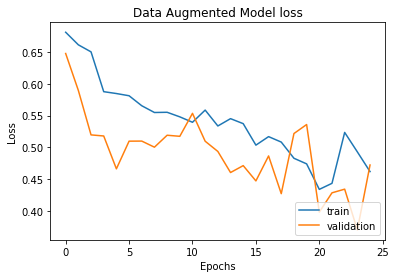

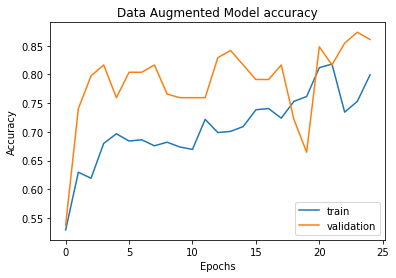

In [110]:
# Training history
print(history.history.keys())
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#plt.yscale('log')
plt.title('Data Augmented Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# Accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Data Augmented Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

### Saving the model

In [111]:
aug_model.save('/content/gdrive/MyDrive/cnn_model/augmented.h5')

# Evaluate and compare the performances of the two models on test dataset

In [112]:
# Load models
model = load_model('/content/gdrive/MyDrive/cnn_model/model.h5')
aug_model = load_model('/content/gdrive/MyDrive/cnn_model/augmented.h5')

# Load test set
x_test, y_test = read_imgs('/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Test/', [0,1])

## model

In [113]:
# Trai set
model.evaluate(x_train, y_train)

# Validation set
model.evaluate(x_test, y_test)

# Test set
model.evaluate(x_val, y_val)

# Classification report
y_test_pred = model.predict(x_test)
print(classification_report(y_test, y_test_pred.round()))

5/5 [==============================] - 0s 73ms/step - loss: 0.1540 - accuracy: 0.9497
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        84
           1       0.94      0.95      0.94        77

    accuracy                           0.94       161
   macro avg       0.94      0.94      0.94       161
weighted avg       0.94      0.94      0.94       161



## aug model

In [114]:
# Trai set
aug_model.evaluate(x_train, y_train)

# Validation set
aug_model.evaluate(x_test, y_test)

# Test set
aug_model.evaluate(x_val, y_val)

# Classification report
y_test_pred = aug_model.predict(x_test)
print(classification_report(y_test, y_test_pred.round()))

5/5 [==============================] - 0s 76ms/step - loss: 0.3872 - accuracy: 0.8679
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        84
           1       0.91      0.90      0.90        77

    accuracy                           0.91       161
   macro avg       0.91      0.91      0.91       161
weighted avg       0.91      0.91      0.91       161



## Confusion Matrix

## model

Confusion matrix, without normalization
[[79  5]
 [ 4 73]]


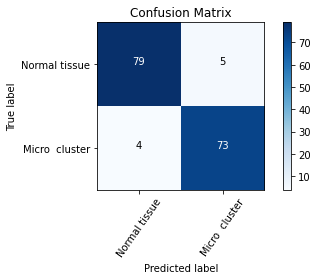

In [115]:
cm = confusion_matrix(y_test, model.predict(x_test).round())
cm_plot_label =['Normal tissue', 'Micro  cluster']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix')

## aug model

Confusion matrix, without normalization
[[77  7]
 [ 8 69]]


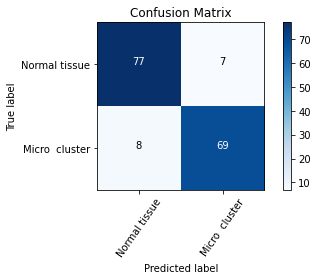

In [116]:
cm = confusion_matrix(y_test, aug_model.predict(x_test).round())
cm_plot_label =['Normal tissue', 'Micro  cluster']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix aug')

## ROC curve

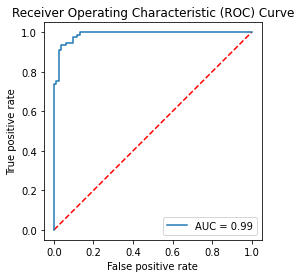

In [117]:
plot_roc_curve(y_test, model.predict(x_test))

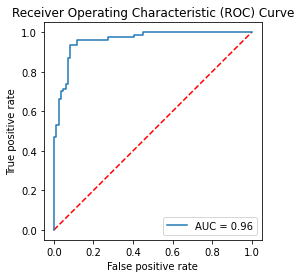

In [118]:
plot_roc_curve(y_test, aug_model.predict(x_test))

# **STEP 5**: Cross validation procedure

In [119]:
# Load data
train_dataset_path = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Train'
x_train_raw, y_train_raw = read_imgs(train_dataset_path, [0, 1])
test_dataset_path = '/content/gdrive/MyDrive/DATASETS_new/IMAGES/Mammography_micro/Test'
x_test_raw, y_test_raw = read_imgs(test_dataset_path, [0, 1])

# Concatenates train and test images in a single array and do the same on train and test labels arrays. 
#X_tot = np.concatenate((x_train_raw, x_test_raw), axis=0)
#y_tot = np.concatenate((y_train_raw, y_test_raw), axis=0)

Folder 0
Folder 1
Folder 2
Folder 3
Folder 4


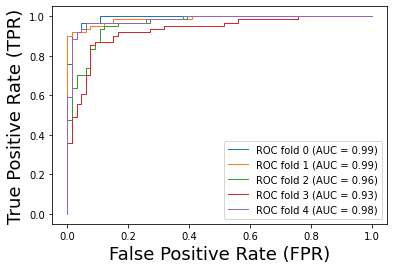

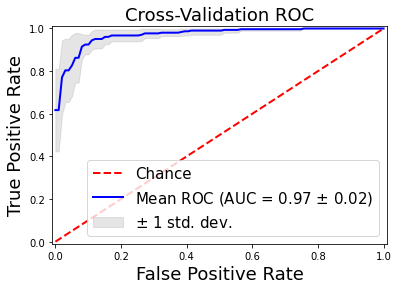


TRAIN - Average scores:
Train accuracy: 0.88 +/- 0.05
Train loss: 0.28 +/- 0.13

VAL - Average scores:
Val accuracy: 0.86 +/- 0.07
Val loss: 0.31 +/- 0.17

TEST - Average scores:
Test accuracy: 0.86 +/- 0.07
Test loss: 0.34 +/- 0.19


In [120]:
def plot_cv_roc(X, y, X_test, y_test, model, n_splits=5):
    """
    Implement the K-cross validation procedure using StratifiedKFold
    with a model supplied by the user.
    It is a variation of k-fold which returns stratified folds: each set contains
    approximately the same percentage of samples of each target class as the complete set.
    Thus, plot the roc curves obtained from each configuration and the average roc curve.
    Finally, print the average scores of loss and accuracy on the train, validation and test set.

    Parameters
    ----------
    X : numpy array
        Array of train images.
    y : numpy array
        Array of train labels.
    X_test : numpy array
        Array of test images.
    y_test : numpy array
        Array of test labels.
    model : keras model
        Model to train for cross validation.
    n_splits : int
        Number of folders.

    Returns
    -------
    None
    
    """

    try:
      y = y.to_numpy()
      X = X.to_numpy() 
    except AttributeError:
      pass

    # Creates per-fold accuracy and loss lists
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    test_acc = []
    test_loss = []

    cv = StratifiedKFold(n_splits, shuffle=True)
    #https://scikit-learn.org/stable/modules/cross_validation.html

    tprs = []
    aucs = []
    interp_fpr = np.linspace(0, 1, 100)

    # Compiles the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Saving the weights before training as reset before each training
    model.save_weights('reset_model.h5')

    plt.figure(1)

    i = 0
    for train, val in cv.split(X, y):

      print(f'Folder {i}')
      
      # Reset the untrained model weights saved before
      model.load_weights('reset_model.h5')
      prediction = model.fit(X[train],
                           y[train],
                           batch_size=32,
                           epochs=25,
                           verbose=0
                           )
    
      # Evaluates the efficiency of the model
      scores_train = model.evaluate(X[train], y[train], verbose=0)
      scores_val = model.evaluate(X[val], y[val], verbose=0)
      scores_test = model.evaluate(X_test, y_test, verbose=0)

      y_val_pred = model.predict(X[val])
      fpr, tpr, thresholds = roc_curve(y[val], y_val_pred)
      interp_tpr = interp(interp_fpr, fpr, tpr)
      tprs.append(interp_tpr)

      # Compute ROC curve and area under the curve    
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=1,
              #alpha=0.3,
              label=f'ROC fold {i} (AUC = {roc_auc:.2f})'
      )
      # Train
      train_loss.append(scores_train[0])
      train_acc.append(scores_train[1])

      # Validation
      val_loss.append(scores_val[0])
      val_acc.append(scores_val[1])
    
      # Test
      test_loss.append(scores_test[0])
      test_acc.append(scores_test[1])
    
      i += 1

    plt.legend()
    plt.xlabel('False Positive Rate (FPR)', fontsize=18)
    plt.ylabel('True Positive Rate (TPR)', fontsize=18)
    plt.show()

    plt.figure(2)
    plt.plot([0, 1], [0, 1],
            linestyle='--',
            lw=2,
            color='r',
            label='Chance',
            #alpha=.8
    )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(interp_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(interp_fpr, mean_tpr,
            color='b',
            label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})',
            lw=2,
            #alpha=.8
            )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(interp_fpr, tprs_lower, tprs_upper,
                    color='grey',
                    alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Cross-Validation ROC', fontsize=18)
    plt.legend(loc="lower right", prop={'size': 15})
    plt.show()
r
    # Computing and printing average scores
    print('\nTRAIN - Average scores:')
    print(f'Train accuracy: {np.mean(train_acc):.2f} +/- {np.std(train_acc):.2f}')
    # Calculare loss error as maximum value error
    err_train_loss = (max(train_loss)-min(train_loss))/2
    print(f'Train loss: {np.mean(train_loss):.2f} +/- {err_train_loss:.2f}')

    print('\nVAL - Average scores:')
    print(f'Val accuracy: {np.mean(val_acc):.2f} +/- {np.std(val_acc):.2f}')
    # Calculare loss error as maximum value error
    err_val_loss = (max(val_loss)-min(val_loss))/2
    print(f'Val loss: {np.mean(val_loss):.2f} +/- {err_val_loss:.2f}')

    print('\nTEST - Average scores:')
    print(f'Test accuracy: {np.mean(test_acc):.2f} +/- {np.std(test_acc):.2f}')
    # Calculare loss error as maximum value error
    err_test_loss = (max(test_loss)-min(test_loss))/2
    print(f'Test loss: {np.mean(test_loss):.2f} +/- {err_test_loss:.2f}')

  
INPUT_SHAPE = (60, 60, 1)
plot_cv_roc(X=x_train_raw, y=y_train_raw, X_test=x_test, y_test=y_test, model=cnn_model(shape=INPUT_SHAPE, verbose=False), n_splits=5)